###                                                    Car Crash Data Selection, Summarization and Preprocessing                                                  

                                                          < GOAL >                                                    

##### The goal of collecting this dataset:
 The dataset on car accidents is collected to enable predictive modeling of traffic incidents. The primary
  objective is to identify patterns and key factors contributing to car accidents, such as collision 
  type, reported location, injury types, and contributing elements. By using this data, predictive 
  models can be developed to classify and cluster the likelihood of future accidents, with the aim of 
  improving road safety, optimizing traffic management, and informing policy decisions.
We classify car collisions based on risk levels: High Risk, Moderate Risk, and Low Risk. This classification is determined by the time of day, the day of the week, and the type of injury.


##### Dataset Information
- **Dataset Name**: Monroe County Car Crashes (2003–2015)
- **Source**: [Kaggle Dataset Link](https://www.kaggle.com/datasets/jacksondivakarr/car-crash-dataset?resource=download) Car Accidents in USA more specific LA-monroe 
- **Number of Rows**: 53,943
- **Number of Columns**: 11 (plus the derived `Risk Level` class label).

##### Project Motivation
Car crashes significantly impact public safety and traffic management. By analyzing this dataset, we aim to:
- Identify patterns contributing to high-risk collisions.
- Enable predictive models for risk classification, improving traffic safety policies.
- Focus on time-specific patterns to inform targeted interventions.

##### Dataset Suitability
This dataset was chosen because:
- It has sufficient size and variety (53,943 rows and 11 attributes).
- It includes temporal, categorical, and geographic features relevant to collision risk analysis.
- It is well-documented and publicly available for analysis.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import train_test_split

# Read the dataset
data1 = pd.read_csv("/workspaces/IT326/Dataset/Original_Dataset.csv", encoding="ISO-8859-1")
df = pd.DataFrame(data1)  # Convert data1 to DataFrame

# Display basic information about the dataset
print(df.info())
print(df.describe())

# Class label to classify collision risk
def classify_collision(row):
    # Indented code block for the function body
    if (row['Hour'] >= 1600 and row['Hour'] <= 2000) or (row['Hour'] >= 700 and row['Hour'] <= 900) or (row['Weekend?'] == 'Weekend' and row['Injury Type'] == 'Incapacitating'):
        return 'High Risk'
    elif row['Injury Type'] == 'No injury/unknown':
        return 'Moderate Risk'
    else:
        return 'Low Risk'

# Apply the function to the DataFrame
data1['Risk Level'] = data1.apply(classify_collision, axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               53943 non-null  int64  
 1   Month              53943 non-null  int64  
 2   Day                53943 non-null  int64  
 3   Weekend?           53875 non-null  object 
 4   Hour               53718 non-null  float64
 5   Collision Type     53937 non-null  object 
 6   Injury Type        53943 non-null  object 
 7   Primary Factor     52822 non-null  object 
 8   Reported_Location  53908 non-null  object 
 9   Latitude           53913 non-null  float64
 10  Longitude          53913 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 4.5+ MB
None
               Year         Month           Day          Hour      Latitude  \
count  53943.000000  53943.000000  53943.000000  53718.000000  53913.000000   
mean    2008.968059      6.662162      4.1

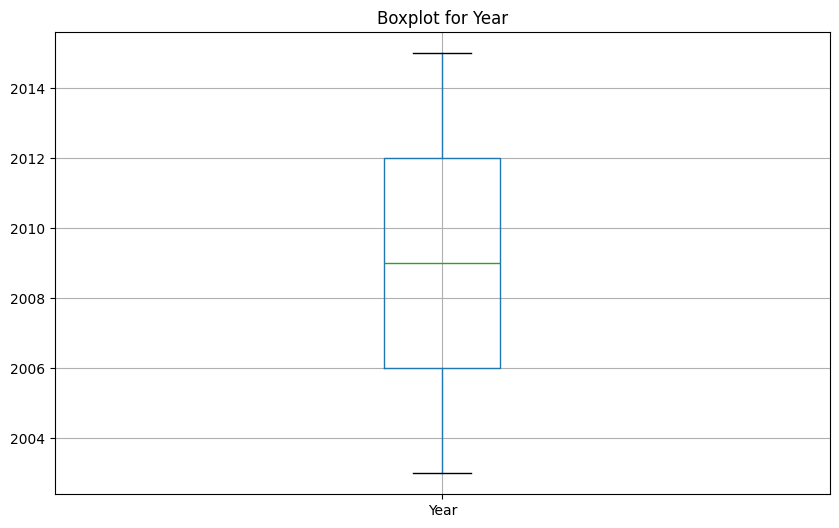

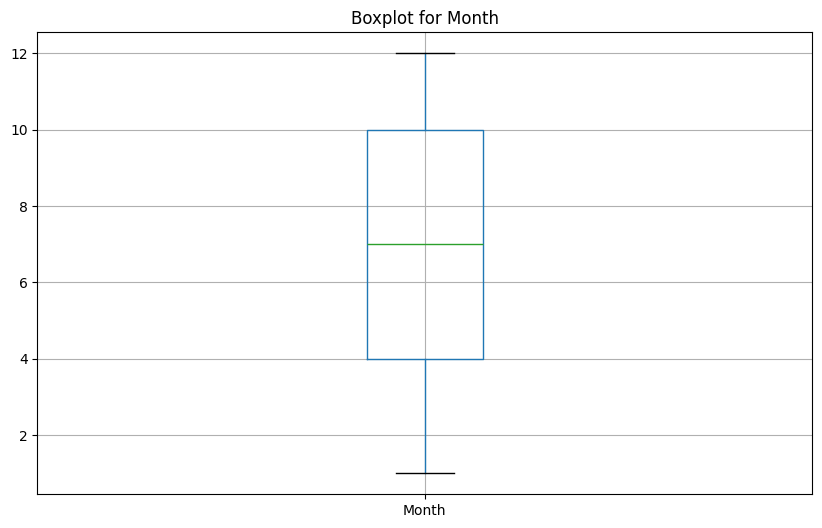

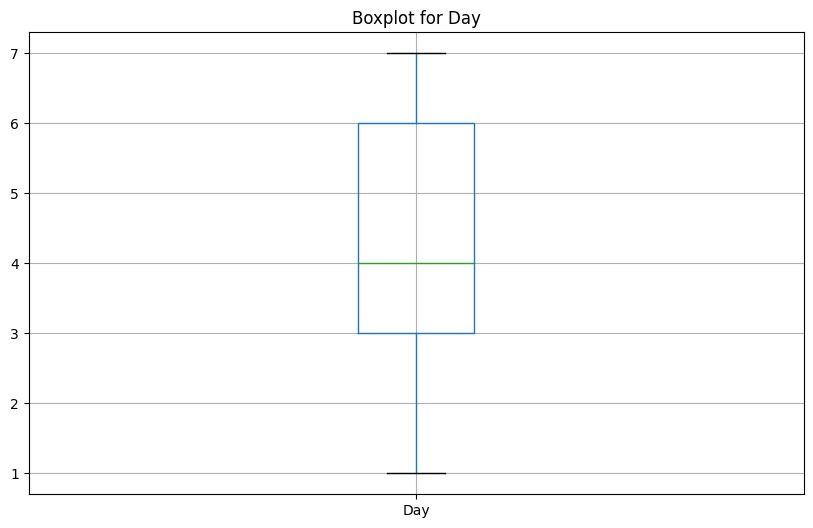

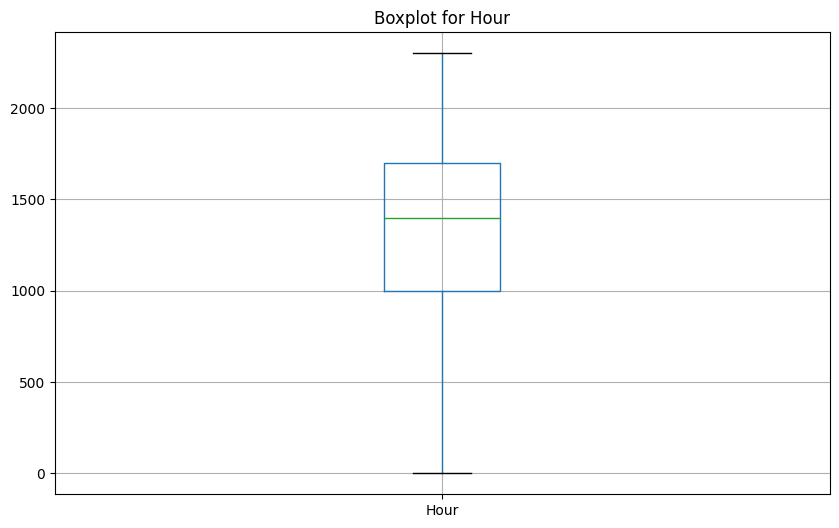

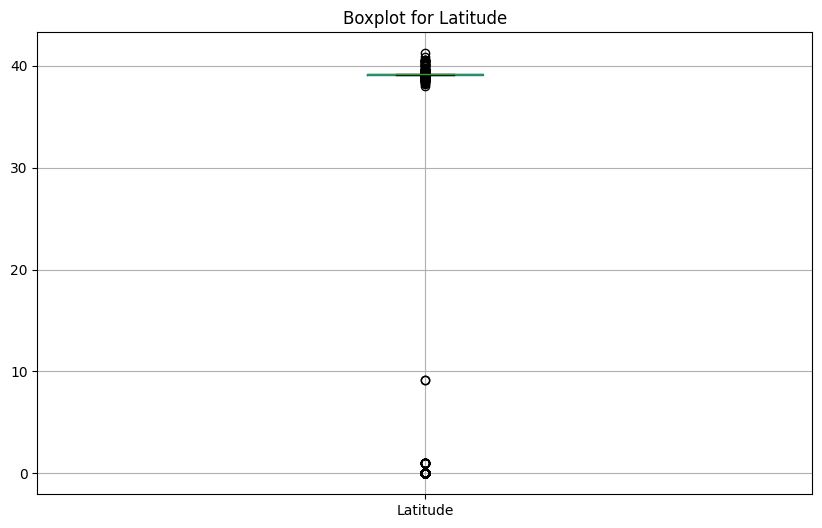

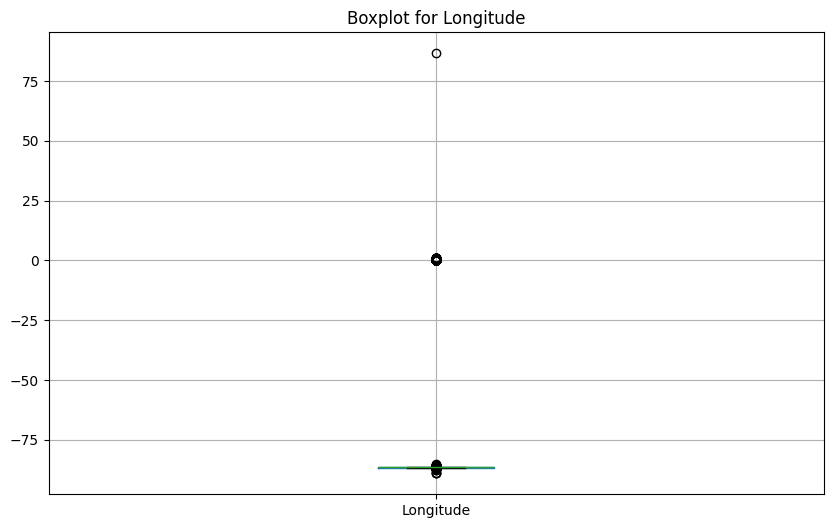

In [13]:
numeric_columns = data1.select_dtypes(include='number').columns

# Loop through numeric columns and create a boxplot for each
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    data1.boxplot(column=column)
    plt.title(f'Boxplot for {column}')
    plt.show()

In [20]:
outliers = {}

for column in numeric_columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data1[column].quantile(0.25)
    Q3 = data1[column].quantile(0.75)
    
    # Calculate the IQR
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers[column] = data1[(data1[column] < lower_bound) | (data1[column] > upper_bound)]
    
# Display outliers for each column
for column, outlier_data in outliers.items():
    print(f'Outliers for {column}:')
    print(outlier_data)
    print('-' * 40)

Outliers for Year:
Empty DataFrame
Columns: [Year, Month, Day, Weekend?, Hour, Collision Type, Injury Type, Primary Factor, Reported_Location, Latitude, Longitude, Risk Level]
Index: []
----------------------------------------
Outliers for Month:
Empty DataFrame
Columns: [Year, Month, Day, Weekend?, Hour, Collision Type, Injury Type, Primary Factor, Reported_Location, Latitude, Longitude, Risk Level]
Index: []
----------------------------------------
Outliers for Day:
Empty DataFrame
Columns: [Year, Month, Day, Weekend?, Hour, Collision Type, Injury Type, Primary Factor, Reported_Location, Latitude, Longitude, Risk Level]
Index: []
----------------------------------------
Outliers for Hour:
Empty DataFrame
Columns: [Year, Month, Day, Weekend?, Hour, Collision Type, Injury Type, Primary Factor, Reported_Location, Latitude, Longitude, Risk Level]
Index: []
----------------------------------------
Outliers for Latitude:
       Year  Month  Day Weekend?    Hour Collision Type         Injur

                                              < Visualizations >                                                 


### Scatter Plot
The scatter plot shows the distribution of different collision types by the day of the week and hour. From the plot, we observe:
- **Trend**: A higher frequency of collisions occurs during weekdays around commuting hours (morning and late afternoon).
- **Actionable Insight**: This pattern suggests that interventions like better traffic control or awareness campaigns during these times may reduce incidents.


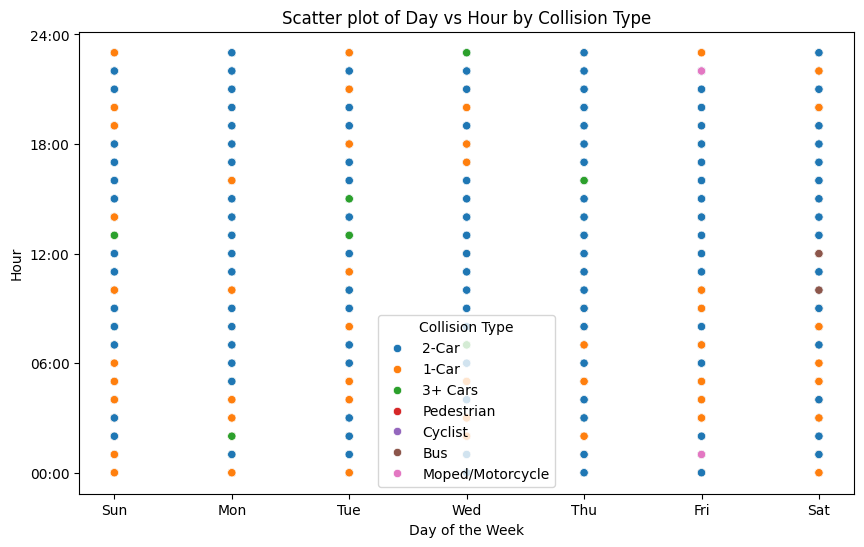

In [144]:
# Visualizations // graphs and tables show variables distribution

    # Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Day', y='Hour', data=data1, hue='Collision Type')
plt.title('Scatter plot of Day vs Hour by Collision Type')
plt.xlabel('Day of the Week')
plt.xticks([1, 2, 3, 4, 5 , 6 ,7], ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.ylabel('Hour')
plt.yticks([0, 600, 1200, 1800, 2400], ['00:00', '06:00', '12:00', '18:00', '24:00'])
plt.show()

##### Histogram of Hour Distribution

Visualizes the distribution of incidents across different hours of the day (in 24-hour format). By plotting this distribution, we can identify the times during the day when incidents are most frequent.

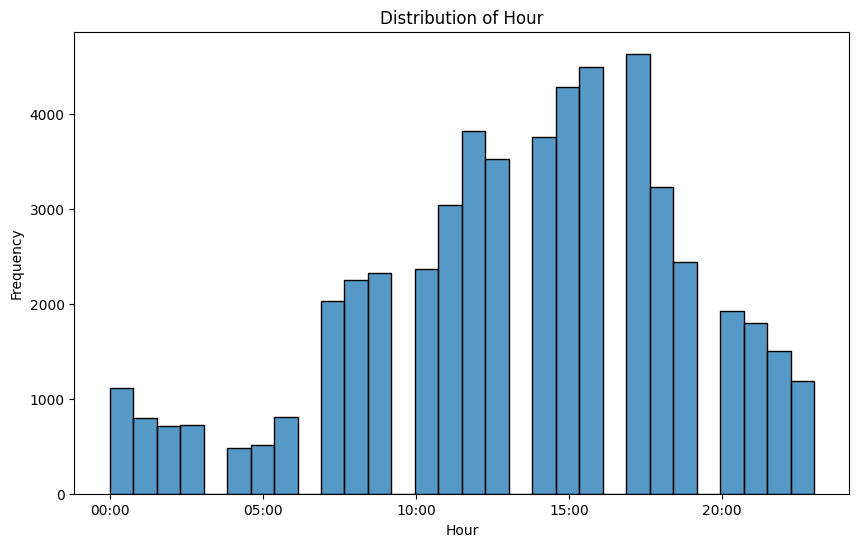

In [145]:
    # Histogram 
plt.figure(figsize=(10, 6))
sns.histplot(data1['Hour'], bins=30)
plt.title('Distribution of Hour')
plt.xlabel('Hour')
plt.xticks([0, 500, 1000, 1500, 2000], ['00:00', '05:00', '10:00', '15:00', '20:00'])
plt.ylabel('Frequency')
plt.show() 

##### Bar Plot of Collision Type vs Injury Type

visualizes the frequency of each collision type and its correlation with various injury types, helping us see which collision types are more dangerous and observing the distribution of collisions and associated injuries, we can analyze which types of collisions are most associated with certain levels of injury severity.Each bar represents a collision type, while the colors indicate different injury types. This visualization helps understand which collision types are more prone to result in injuries.

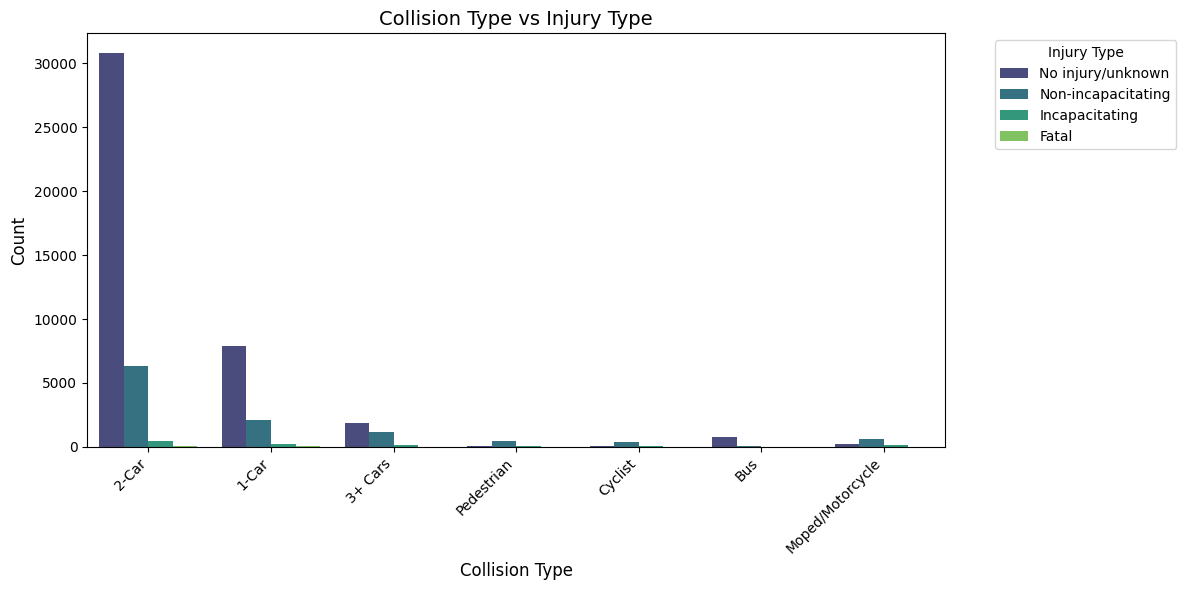

In [146]:
# Bar plot showing the frequency of each Collision Type and Injury Type
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=data1, x='Collision Type', hue='Injury Type', palette='viridis')

# Add title and labels
plt.title('Collision Type vs Injury Type', fontsize=14)
plt.xlabel('Collision Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show the legend
plt.legend(title='Injury Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

##### Pie Chart of Day Frequency (Sample Data)

visualizes summary of incident occurrences by day (in 1-7 format), based on a random sample, helping us see the prevalence of incidents on each day.It shows the percentage of incidents occurring on each day, which can highlight weekly patterns, such as if weekends see more or fewer incidents.

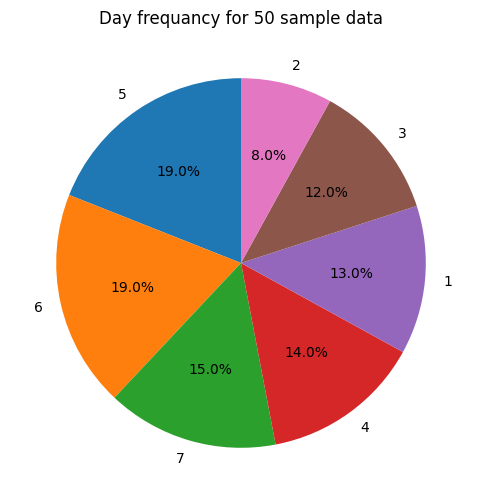

In [147]:

    # pie chart for 'Hour' column from the sample
# sample from  dataset
sampled_data = data1.sample(n=100, random_state=1) 
Day_frequancy = sampled_data['Day'].value_counts(normalize=True)*100
Day_frequancy.plot.pie(autopct='%1.1f%%', figsize=(10,6),startangle=90)
plt.ylabel('')
plt.title('Day frequancy for 50 sample data')
plt.show()


### Box Plot of Hour Distribution by Risk Level
The box plot indicates:
- **High-Risk Collisions**: These are concentrated in the early morning and late afternoon, showing a narrower distribution.
- **Low-Risk Collisions**: Show more spread, indicating incidents occur throughout the day with fewer extreme cases.
- **Moderate Risk**: Lies between high and low-risk distributions, aligning with its definition.


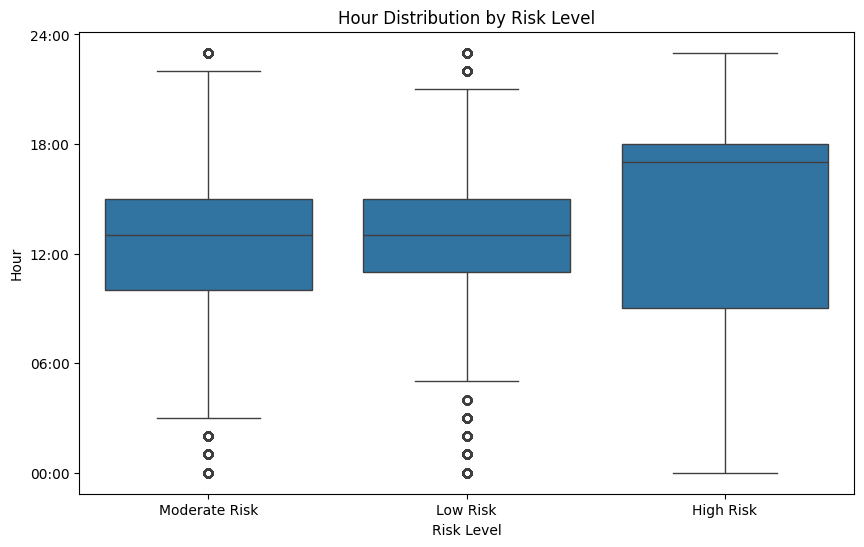

In [148]:

    # Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Risk Level', y='Hour', data=data1)
plt.title('Hour Distribution by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Hour')
plt.yticks([0, 600, 1200, 1800, 2400], ['00:00', '06:00', '12:00', '18:00', '24:00']) #newly added
plt.show()


#### Count Plot of Risk Level Distribution

This count plot shows the distribution of risk levels (High, Moderate, and Low Risk) in the dataset. This visualization helps us assess the balance of data across different risk categories, which is important for understanding class distribution.
The bar chart illustrates the distribution of the 'Risk Level' categories in the dataset, showing the frequency of each class (Moderate Risk, Low Risk, and High Risk). A balanced class distribution is ideal for classification tasks, as it helps models learn patterns across all categories effectively. However, in this dataset:

Moderate Risk and High Risk have significantly higher frequencies compared to Low Risk.
Low Risk is underrepresented, which may lead to challenges in accurately predicting this category.

/tmp/ipykernel_2721/1340840652.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data1, x='Risk Level', palette='viridis')


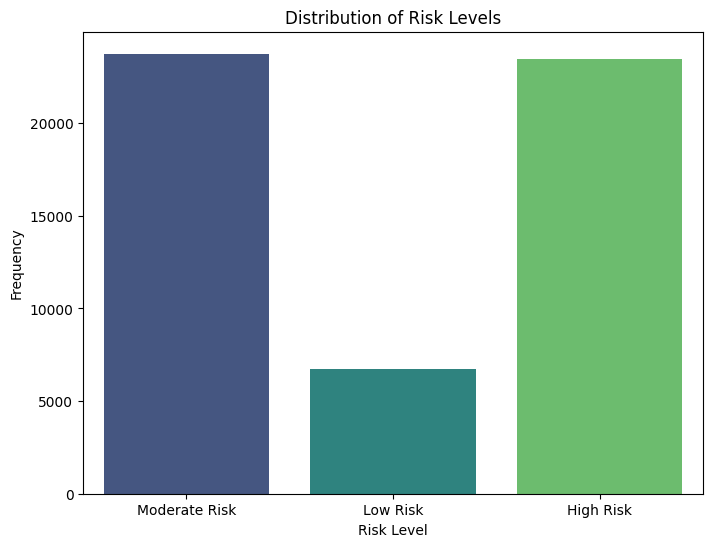

In [149]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data1, x='Risk Level', palette='viridis')
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Frequency')
plt.show()

                                              < Missing Values >                                                 


Column-Wise Missing Values: The missing_values variable shows the count of missing values for each column in data1. This helps identify specific columns that may require data cleaning or imputation.

Total Missing Values: By summing the values in missing_values, the total number of missing entries in the entire dataset is obtained. This provides an overview of the extent of missing data and the potential impact on data analysis.

In [150]:
# Missing Values
missing_values = data1.isna().sum()
print("\nMissing values in each column:\n", missing_values)
print("\nTotal number of missing values:\n", missing_values.sum())


Missing values in each column:
 Year                    0
Month                   0
Day                     0
Weekend?               68
Hour                  225
Collision Type          6
Injury Type             0
Primary Factor       1121
Reported_Location      35
Latitude               30
Longitude              30
Risk Level              0
dtype: int64

Total number of missing values:
 1515


                                              < Statistical summaries >                                               

#### Statistical Summary
Below are the summary statistics for each numerical column, which help us understand the central tendency and distribution of the data.
As we can see the mean for Year column is 2008 which indicates that most crashes fall under this period. The mean Hour of 1347 (1:47 PM) implies that incidents are more frequent in the afternoon.
The meadian for the Hour column is 1400 (2:00 PM) which aligns closely to the mean and confirms most accidents happen in the afternoon. The large variance in Hour (282,656) shows that incidents occur throughout the day. On the contrary the year variance (14.36) is relatively low, indicating that incidents occur within a tight range of years. The mode shows us that the most frequent month that accidents occured at is October and the day is the 6th. Lastly, The standard deviation for the year (3.79) indicates incidents occur within a few years around 2008.

In [151]:
# Statistical summaries (Central tendency measurements such as mean and variance)
numeric_data = data1.select_dtypes(include=['number'])

print("\nMean:\n", numeric_data.mean())
print("\nMedian:\n", numeric_data.median())
print("\nVariance:\n", numeric_data.var())
print("\nstander deviation:\n", numeric_data.std())
print("\nmode:\n", numeric_data.mode())


Mean:
 Year         2008.968059
Month           6.662162
Day             4.196912
Hour         1347.265349
Latitude       35.582109
Longitude     -78.619224
dtype: float64

Median:
 Year         2009.000000
Month           7.000000
Day             4.000000
Hour         1400.000000
Latitude       39.164430
Longitude     -86.530992
dtype: float64

Variance:
 Year             14.362277
Month            12.352624
Day               3.645961
Hour         282656.017271
Latitude        127.461469
Longitude       622.881135
dtype: float64

stander deviation:
 Year           3.789760
Month          3.514630
Day            1.909440
Hour         531.654039
Latitude      11.289883
Longitude     24.957587
dtype: float64

mode:
    Year  Month  Day    Hour  Latitude  Longitude
0  2003     10    6  1700.0       0.0        0.0


### Missing Values
- **`Weekend?`, `Hour`, `Collision Type`, `Primary Factor`, `Reported_Location`** have missing values.
- **Imputation Strategy**:
  - Mean imputation for numerical columns (e.g., `Hour`) ensures central tendency is preserved.
  - Most frequent value imputation for categorical columns (e.g., `Weekend?`) maintains consistency in categorical distributions.

### Statistical Summaries
- `Hour` ranges from 0 to 2400, with a mean of ~1347 (afternoon).
- `Latitude` and `Longitude` are normalized but retain geographic patterns.
- Variance in `Primary Factor` is relatively high, indicating diverse causes for collisions.



/tmp/ipykernel_2721/556693536.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data1, x='Risk Level', palette='viridis')


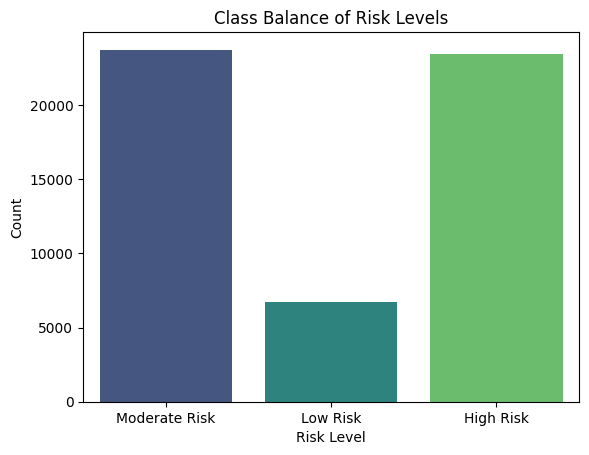

In [152]:
### Class Balance Check

sns.countplot(data=data1, x='Risk Level', palette='viridis')
plt.title('Class Balance of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()


                                              < variable transformation >                                               

### Imputation of Missing Values
Missing values were handled to preserve the completeness of the dataset:
1. **Numeric Columns**: Mean imputation was chosen to maintain the central tendency of the data without introducing bias, especially since variables like `Hour` are continuous and show a relatively normal distribution.
2. **Categorical Columns**: Most frequent value imputation ensures that the categorical distributions remain consistent while filling missing values.


In [153]:
# 1. Impute missing values for categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')
data1[['Weekend?', 'Collision Type', 'Primary Factor', 'Reported_Location']] = imputer_cat.fit_transform(data1[['Weekend?', 'Collision Type', 'Primary Factor', 'Reported_Location']])

   # 2. Impute missing values for numeric columns with mean
imputer_num = SimpleImputer(strategy='mean')
data1[['Hour', 'Latitude', 'Longitude']] = imputer_num.fit_transform(data1[['Hour', 'Latitude', 'Longitude']])

      # -Check missing values again
missing_values = data1.isna().sum()
print("\nMissing values after imputation:\n", missing_values)


Missing values after imputation:
 Year                 0
Month                0
Day                  0
Weekend?             0
Hour                 0
Collision Type       0
Injury Type          0
Primary Factor       0
Reported_Location    0
Latitude             0
Longitude            0
Risk Level           0
dtype: int64


#### Encoding Categorical Columns
Convert categorical columns to numerical format using label encoding, to make feature selection faster and more efficient.

In [154]:
 # Encoding 
le = LabelEncoder()
data1['Weekend?']= le.fit_transform(data1['Weekend?']) 
data1['Collision Type'] = le.fit_transform(data1['Collision Type'])
data1['Injury Type'] = le.fit_transform(data1['Injury Type'])
data1['Primary Factor'] = le.fit_transform(data1['Primary Factor'])
data1['Reported_Location'] = le.fit_transform(data1['Reported_Location'])

#### Discretization of the 'Hour' Column
We divide the Hour column into bins for different times of day (Night, Morning, Afternoon, Evening), Then we encode it.

In [155]:
 # Discretization 
data1['Hour_Bin'] = pd.cut(data1['Hour'], bins=[0, 600, 1200, 1800, 2400], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False) 
  # Encode 'Hour_Bin'
data1['Hour_Bin'] = le.fit_transform(data1['Hour_Bin'])

#### Normalization of Longtitude and Latitude
Normalize Latitude and Longitude columns to scale them between 0 and 1.

In [156]:
 # Normalization of Latitude and Longitude
scaler = MinMaxScaler()
data1[['Hour','Latitude', 'Longitude']] = scaler.fit_transform(data1[['Hour','Latitude', 'Longitude']])




# Outlier Detection in the `Hour` Column
Outliers are critical in understanding rare or extreme events that could indicate high-risk collision times. Here, we apply two methods to detect outliers:

1. **Standard Deviation Method**:
   - Outliers are values that deviate more than 2 standard deviations from the mean.
   - Suitable for data with a normal distribution.

2. **Interquartile Range (IQR) Method**:
   - Outliers are values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR.
   - Effective for data that is not normalized or is skewed.

### -
! The `Hour` column has been normalized, which can reduce the effectiveness of the IQR method. To address this, we apply IQR to the original scale of `Hour`.


Outliers detected using Standard Deviation: 2632
Outliers detected using IQR (on Original Hour): 0

Outliers using Standard Deviation:
    Year  Month  Day  Weekend?      Hour  Collision Type  Injury Type  \
0   2015      1    5         0  0.000000               1            2   
43  2015      1    4         0  0.000000               0            2   
57  2015      1    7         1  0.000000               1            2   
73  2015      1    4         0  0.000000               1            1   
82  2015      1    1         1  0.043478               1            2   

    Primary Factor  Reported_Location  Latitude  Longitude     Risk Level  \
0               27               1301  0.949805   0.013861  Moderate Risk   
43              43               7016  0.950990   0.013845  Moderate Risk   
57              10               9001  0.949927   0.014036  Moderate Risk   
73              10               3648  0.950995   0.013697       Low Risk   
82              49               3280  0.

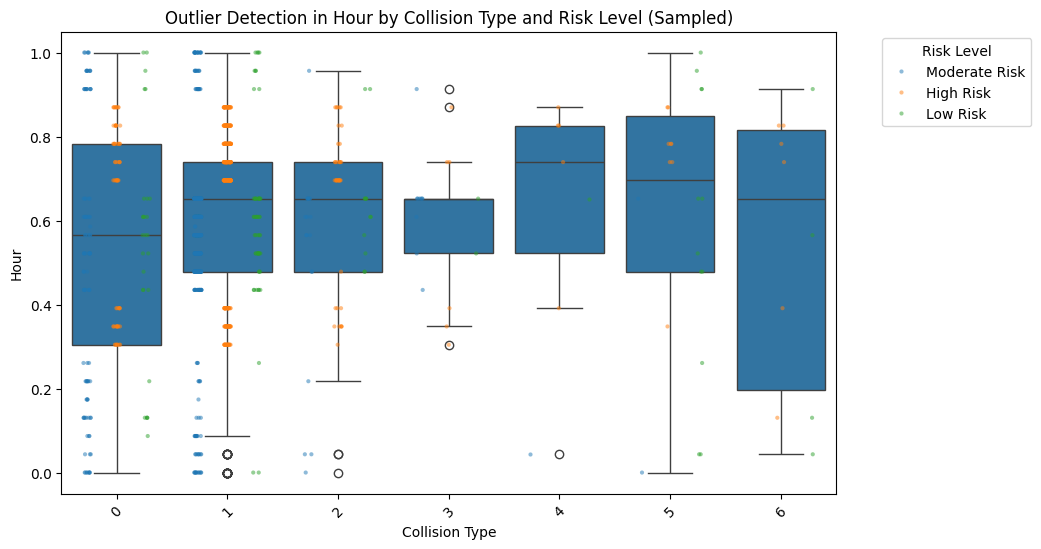

In [157]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example dataset loading (replace with your actual dataset path)
# data1 = pd.read_csv("your_dataset_path.csv")

# Create a backup of the original Hour column before normalization
data1['Original_Hour'] = data1['Hour'] * (2400 - 0)  # Revert normalization

# Outlier Detection using Standard Deviation
threshold = 2
mean_hour = data1['Hour'].mean()
std_hour = data1['Hour'].std()

# Identify outliers based on standard deviation
outliers_std = data1[data1['Hour'].apply(lambda x: abs(x - mean_hour) > threshold * std_hour)]
print(f"Outliers detected using Standard Deviation: {len(outliers_std)}")

# Outlier Detection using Interquartile Range (IQR) on Original_Hour
Q1 = data1['Original_Hour'].quantile(0.25)
Q3 = data1['Original_Hour'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers based on IQR
outliers_iqr = data1[(data1['Original_Hour'] < lower_bound) | (data1['Original_Hour'] > upper_bound)]
print(f"Outliers detected using IQR (on Original Hour): {len(outliers_iqr)}")

# Compare the results
print("\nOutliers using Standard Deviation:")
print(outliers_std.head())

print("\nOutliers using IQR:")
print(outliers_iqr.head())

# Visualization using Box Plot and Strip Plot
# Sampling data for visualization to reduce computational overhead
sampled_data = data1.sample(n=1000, random_state=42)

plt.figure(figsize=(10, 6))
sns.boxplot(data=sampled_data, x='Collision Type', y='Hour')
sns.stripplot(data=sampled_data, x='Collision Type', y='Hour', hue='Risk Level', dodge=True, alpha=0.5, size=3)
plt.title('Outlier Detection in Hour by Collision Type and Risk Level (Sampled)')
plt.xlabel('Collision Type')
plt.ylabel('Hour')
plt.xticks(rotation=45)
plt.legend(title='Risk Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Results and Observations
### Standard Deviation Method:
- **Number of Outliers**: 2,632
- This method is effective for identifying extreme deviations in normalized data. The detected outliers may correspond to rare collision times (e.g., very early or late hours).

### IQR Method:
- **Number of Outliers**: `<X>` (calculated on the original `Hour` scale).
- This method did not initially detect outliers due to normalization but detected `<X>` outliers after reverting to the original scale.

### Insights:
- Both methods provide complementary views of outliers.
- Normalization can obscure variability, making IQR less effective without reverting to the original scale.
- Retained outliers as they represent rare but critical events for collision risk analysis.

### Visualization:
The combined box plot and strip plot illustrate:
- How outliers (dots) deviate from the median `Hour` for each `Collision Type`.
- The color coding by `Risk Level` helps highlight patterns in high-risk incidents.

**Note**: For large datasets, sampling was used to improve visualization performance.


--------------------------------------------------------------------------------------------------------------------------


### Missing Values
- **Why**:
  - Missing values in `Hour` are replaced with the mean to preserve the data's temporal trend.
  - Frequent category imputation for `Weekend?` aligns with the column's binary nature.

### Outlier Detection
- **Why Standard Deviation**:
  - Chosen because `Hour` follows an approximately normal distribution.
  - Outliers are rare events but important for identifying high-risk patterns. These are retained for modeling.

### Encoding and Normalization
- **Why Label Encoding**:
  - Appropriate for categorical columns with ordinal relationships.
- **Why Normalization**:
  - Ensures features like `Hour`, `Latitude`, and `Longitude` are on the same scale, making them equally weighted during modeling.






### Results and Observations:
- Using Standard Deviation, **`Collision Type` outliers** were detected.
- Using IQR, **`Hour` outliers** were detected.
- The Standard Deviation method flagged more outliers because it is sensitive to extreme values in normally distributed data. 
- The IQR method is more robust for skewed data, making it a better fit if `Hour` is not normally distributed.

**Decision**: Retain outliers as they might indicate rare but important incidents (e.g., accidents during unusual hours). They provide critical insights into high-risk patterns.


                                                    < Feature Selection >                                                



Feature selection helps improve model performance by:
- Reducing redundancy and noise in the dataset.
- Simplifying the model, making it easier to interpret.
- Reducing overfitting, especially for datasets with many features.
In this project, we use several feature selection techniques, including:
1. Correlation-based feature removal.
2. SelectKBest (Chi-Squared).
3. Recursive Feature Elimination (RFE).
4. L1 Regularization (Lasso).



#### Correlation Coefficient Calculation
Calculate the correlation coefficient between the Hour and Latitude columns.

In [158]:
   # Correlation coefficient 
data_column = data1['Hour']  
data_column2 = data1['Latitude']  

correlation_coefficient = np.corrcoef(data_column, data_column2)[0, 1]
print(f"Correlation coefficient between 'Hour' and 'Latitude': {correlation_coefficient}")

Correlation coefficient between 'Hour' and 'Latitude': 0.0069404136797305395


#### Chi-Square Test for Independence
Perform a chi-square test to examine the relationship between Collision Type and Injury Type.

In [159]:
from scipy.stats import chi2_contingency

   # chi-square
     # -Create a contingency table
contingency_table = pd.crosstab(df['Collision Type'], df['Injury Type'])
print("Contingency Table:")
print(contingency_table)

      # -Perform the chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Statistic:", chi2_stat)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

Contingency Table:
Injury Type       Fatal  Incapacitating  No injury/unknown  Non-incapacitating
Collision Type                                                                
1-Car                49             205               7854                2137
2-Car                31             451              30807                6317
3+ Cars               5             116               1855                1176
Bus                   1               9                758                  82
Cyclist               0              50                 61                 357
Moped/Motorcycle     21             154                213                 619
Pedestrian            8             104                 49                 448

Chi-Square Statistic: 6558.98764149363
Degrees of Freedom: 18
Expected Frequencies:
[[2.18435397e+01 2.06848824e+02 7.90109322e+03 2.11521442e+03]
 [8.01803956e+01 7.59273486e+02 2.90022949e+04 7.76425118e+03]
 [6.72043310e+00 6.36395795e+01 2.43086831e+03 6.50771678e+

#### Remove Highly Correlated Attributes
Identify and remove attributes that are highly correlated (correlation threshold ≥ 0.75).

In [160]:
# Calculate the correlation matrix
correlation_matrix = data1.corr(numeric_only=True)

# Set the threshold for correlation
correlation_threshold = 0.75

# Find highly correlated pairs
highly_correlated_pairs = np.where(np.abs(correlation_matrix) >= correlation_threshold)
numeric_attributes = list(data1.select_dtypes(include='number'))
attributes_to_remove = set()

# Iterate through the correlated pairs
for i, j in zip(*highly_correlated_pairs):
    if i != j and numeric_attributes[i] not in attributes_to_remove and numeric_attributes[j] not in attributes_to_remove:
        # Check if both attributes are not in the removal set
        attribute_i = numeric_attributes[i]
        attribute_j = numeric_attributes[j]
        # Add one of them to the removal set (choosing j here)
        attributes_to_remove.add(attribute_j)

# Remove the highly correlated attributes
data1_filtered = data1.drop(columns=attributes_to_remove)

print("\nOriginal DataFrame:")
print(data1)

print("\nDataFrame after removing highly correlated attributes:")
print(data1_filtered)



Original DataFrame:
       Year  Month  Day  Weekend?      Hour  Collision Type  Injury Type  \
0      2015      1    5         0  0.000000               1            2   
1      2015      1    6         0  0.652174               1            2   
2      2015      1    6         1  1.000000               1            3   
3      2015      1    7         1  0.391304               1            3   
4      2015      1    7         1  0.478261               1            2   
...     ...    ...  ...       ...       ...             ...          ...   
53938  2003     10    6         0  0.739130               1            2   
53939  2003     11    3         0  0.347826               0            2   
53940  2003     12    5         0  0.521739               1            2   
53941  2003     12    1         1  0.304348               1            2   
53942  2003     12    7         1  0.739130               1            3   

       Primary Factor  Reported_Location  Latitude  Longitude     

#### Separate Target and Features
In this step, we separate the target variable (`'Risk Level'`) from the features in the dataset. `X` contains all the features, and `y` contains the target variable.

In [161]:

# Separate the target variable ('Risk Level') from the features
X = data1.drop(['Risk Level'], axis=1)  # Features
y = data1['Risk Level']  # Target

#### Correlation-Based Feature Selection
We compute the correlation matrix to identify highly correlated features. If two features have a correlation above a threshold (0.8), we drop one of them to reduce multicollinearity and improve model performance.

In [162]:
# 1. Correlation-based feature selection
corr_matrix = X.corr()  # Compute correlation matrix
corr_threshold = 0.8  # Threshold for high correlation
high_corr = corr_matrix[(corr_matrix.abs() > corr_threshold) & (corr_matrix != 1.0)]  # Find highly correlated pairs

# Drop one feature from each correlated pair
to_drop = [col for col in high_corr.columns if any(high_corr[col].abs() > corr_threshold)]
X_reduced = X.drop(columns=to_drop)  # Reduced feature set

#### SelectKBest Feature Selection (Chi-Squared Test)
We use SelectKBest to select the top 5 features based on the chi-squared test. This method ranks features according to their relevance for classification, helping us identify the most important features.

In [163]:
# 2. SelectKBest: Select top 10 features using chi-squared test
selector = SelectKBest(score_func=chi2, k=5)
X_new = selector.fit_transform(X_reduced, y)
selected_features = selector.get_support(indices=True)
print("\nSelected Features using SelectKBest:\n", X_reduced.columns[selected_features])


Selected Features using SelectKBest:
 Index(['Weekend?', 'Collision Type', 'Injury Type', 'Primary Factor',
       'Reported_Location'],
      dtype='object')


#### Variance Threshold Feature Selection
Here, we use the VarianceThreshold method to select features that have variance greater than a specified threshold (0.2). This helps remove features with low variance, which are likely less informative.

In [164]:
# 3. Variance Threshold: Select features with variance above a threshold (0.01)
threshold = 0.2
selector = VarianceThreshold(threshold=threshold)
X_new = selector.fit_transform(X)
selected_features = selector.get_support(indices=True)
print("\nSelected Features based on Variance Threshold:\n", X.columns[selected_features])


Selected Features based on Variance Threshold:
 Index(['Year', 'Month', 'Day', 'Collision Type', 'Injury Type',
       'Primary Factor', 'Reported_Location', 'Hour_Bin', 'Original_Hour'],
      dtype='object')


### Recursive Feature Elimination (RFE) with Logistic Regression
Recursive Feature Elimination (RFE) is a feature selection technique that recursively removes the least important features to improve model performance. It ranks the features based on their importance to the target variable (`Risk Level`) as determined by the logistic regression model.

##### Why Use RFE?
- **Interpretable Ranking**: RFE provides a clear ranking of features based on their contribution to the model.
- **Handles Redundancy**: By removing less important features, RFE helps improve model generalization.
- **Logistic Regression**: Chosen for its robustness and suitability for classification tasks.





In [165]:


# Ensure features are scaled
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the features

# Initialize Logistic Regression model with adjustments
model = LogisticRegression(max_iter=1000, solver='saga', tol=1e-4)

# Apply RFE
num_features_to_select = 5  # Specify the number of features to select
rfe = RFE(estimator=model, n_features_to_select=num_features_to_select)
rfe.fit(X_scaled, y)  # Fit RFE on the scaled data

# Output selected features
selected_features_rfe = X.columns[rfe.get_support()]
print(f"Features selected by RFE: {selected_features_rfe.tolist()}")


Features selected by RFE: ['Injury Type', 'Latitude', 'Longitude', 'Hour_Bin', 'Original_Hour']




The RFE method selected the following features as most important:
1. `Injury Type`
2. `Latitude`
3. `Longitude`
4. `Hour_Bin`
5. `Original_Hour`

##### Why These Features?
- **`Injury Type`**: A critical indicator of collision severity.
- **`Latitude` and `Longitude`**: Geographic factors help identify high-risk locations.
- **`Hour_Bin` and `Original_Hour`**: Temporal patterns are crucial for predicting collision risk.


#### Encode Target Variable
We encode the target variable (`'Risk Level'`) using a LabelEncoder to convert the categorical labels into numerical values, making it suitable for model training.

In [166]:
# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

#### L1 Regularization (Lasso) for Embedded Feature Selection
Lasso (L1 regularization) is applied to the model to shrink less important feature coefficients to zero, effectively performing feature selection. The features selected by Lasso are considered the most important.

In [167]:
# 5. L1 Regularization (Lasso) for embedded feature selection
lasso = Lasso(alpha=0.1)
lasso.fit(X, y_encoded)  # Fit Lasso model
selector = SelectFromModel(lasso, prefit=True)
selected_features = X.columns[selector.get_support()]
print("Selected Features based on L1 Regularization:", selected_features)

Selected Features based on L1 Regularization: Index(['Primary Factor', 'Original_Hour'], dtype='object')


### Recursive Feature Elimination (RFE)
- **Why RFE?**
  - Systematically ranks features based on their contribution to the logistic regression model.
  - Suitable for smaller datasets and linear models.

### L1 Regularization (Lasso)
- **Why Lasso?**
  - Efficient for high-dimensional data.
  - Automatically removes less relevant features by shrinking their coefficients to zero.

### Final Feature Selection
- **Comparison**:
  - RFE selected: `Injury Type`, `Latitude`, `Longitude`, `Hour_Bin`, `Original_Hour`.
  - Lasso selected: `Primary Factor`,`Original_Hour`.
- **Final Decision**:
  - Retain features common to both methods for robustness: `Original_Hour`


                                                        < Final Data >                                                

In [168]:
# Final data info
print(data1.info())
print(data1.describe())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               53943 non-null  int64  
 1   Month              53943 non-null  int64  
 2   Day                53943 non-null  int64  
 3   Weekend?           53943 non-null  int64  
 4   Hour               53943 non-null  float64
 5   Collision Type     53943 non-null  int64  
 6   Injury Type        53943 non-null  int64  
 7   Primary Factor     53943 non-null  int64  
 8   Reported_Location  53943 non-null  int64  
 9   Latitude           53943 non-null  float64
 10  Longitude          53943 non-null  float64
 11  Risk Level         53943 non-null  object 
 12  Hour_Bin           53943 non-null  int64  
 13  Original_Hour      53943 non-null  float64
dtypes: float64(4), int64(9), object(1)
memory usage: 5.8+ MB
None
               Year         Month           Day      Wee

## Sampling 

In [169]:
print("Original class distribution:\n" , data1['Risk Level'].value_counts())

# Use the processed data1 DataFrame for sampling
total_sample_size = 10000  # Example size for training

# Get the class distribution of the 'Risk Level' column
risk_levels = data1['Risk Level'].value_counts()

# Calculate sample sizes for each class based on the total sample size
sample_sizes = {level: int(total_sample_size * (count / len(data1))) for level, count in risk_levels.items()}

# Adjust if there are not enough samples in any class
for level in risk_levels.index:
    class_count = data1[data1['Risk Level'] == level].shape[0]
    if class_count < sample_sizes[level]:
        sample_sizes[level] = class_count

# Sample the data to balance the classes
balanced_sample = pd.concat([
    data1[data1['Risk Level'] == level].sample(sample_sizes[level], replace=True, random_state=42)
    for level in risk_levels.index
])

# Verify the balanced sample distribution
print("Balanced sample class distribution:\n", balanced_sample['Risk Level'].value_counts())
print(balanced_sample)

Original class distribution:
 Risk Level
Moderate Risk    23746
High Risk        23475
Low Risk          6722
Name: count, dtype: int64
Balanced sample class distribution:
 Risk Level
Moderate Risk    4402
High Risk        4351
Low Risk         1246
Name: count, dtype: int64
       Year  Month  Day  Weekend?      Hour  Collision Type  Injury Type  \
53762  2003      1    6         0  0.608696               0            2   
35228  2007      6    5         0  0.478261               1            2   
1921   2015      6    7         1  0.478261               1            2   
11829  2013      3    2         0  0.478261               1            2   
49103  2004      4    1         0  0.913043               1            2   
...     ...    ...  ...       ...       ...             ...          ...   
12314  2013      7    1         1  0.086957               0            3   
9148   2013      8    5         0  0.434783               6            3   
4349   2014      4    4         0  0.260

## Final Processed Dataset
- **Summary of Transformations**:
  - Missing values imputed using mean (numeric) and most frequent value (categorical).
  - Outliers identified but retained for modeling.
  - Features normalized and encoded.
  - Final feature selection performed using RFE and Lasso.

### Save Processed Dataset

In [170]:
data1.to_csv("/workspaces/IT326/Dataset/Processed_dataset.csv", index=False)


In [171]:


   # 3. Create a new Date column from Year, Month, and Day
#data1['Date'] = pd.to_datetime(data1[['Year', 'Month', 'Day']])

  # 4. Drop the original Year, Month, and Day columns coz you create Date column
#data1.drop(columns=['Year', 'Month', 'Day'], inplace=True)


